<a href="https://colab.research.google.com/github/basselkassem/easy21/blob/master/monteControl_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libs

In [1]:
!pip install import_ipynb

In [1]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/easy21


#Monte-Carlo Control in Easy21

- Initialise the value function to zero
- Use a time-varying scalar step-size of αt = 1/N(st,at) where N(s, a) is the number
of times that action a has been selected from state s
- Use e-greedy exploration strategy with et = N0/(N0 + N(st)), where N0 = 100 is a constant, N(s) is the number of times that state s has been visited
- Choose an alternative value for N0, if it helps producing better results. 
- Plot the optimal
value function V∗(s) = max_a[Q∗(s, a)] using axes for dealer and the player values

# Import Libs

In [2]:
import import_ipynb
import environment as env
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

importing Jupyter notebook from environment.ipynb
[   100   1000  10000 100000]
[0 1]
[ 1  2  3  4  5  6  7  8  9 10] (10,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] (21,)
(10, 21)
(10, 21, 2)
[  50  100 1000]
Player:  0
Score: 7
Busted: False
------
Dealer: not its turn yet
Score: 7
Busted: False
reward: 0 is_done: False

Player:  0
Score: 1
Busted: False
------
Dealer: not its turn yet
Score: 7
Busted: False
reward: 0 is_done: False

Player:  0
Score: -3
Busted: True
------
Dealer: not its turn yet
Score: 7
Busted: False
reward: -1 is_done: True



In [0]:
test_easy21 = env.Environment()
next_state, reward, done = test_easy21.init()

# class MonteCarloControl

In [0]:
class MonteCarloControl:

    def __init__(self, episodes_num, N0 = 100):
        self.episodes_num = episodes_num
        self.Nsa = defaultdict(int)
        self.Q = defaultdict(int)
        self.N0 = N0
        self.easy21 = env.Environment(mode = 'no_debug')

    def get_Ns(self, state):
        return self.Nsa[state, 0] + self.Nsa[state, 1]

    def epsilon_greedy(self, state):
        epsilon = self.N0 / (self.N0 + self.get_Ns(state))
        if np.random.random() < epsilon:
            hit = self.Q[state, 0]
            stick = self.Q[state, 1]
            if hit > stick:
                return 0
            if hit == stick:
                return self.easy21.sample_action()
            if hit < stick:
                return 1
        else:
            return self.easy21.sample_action()

    def agent_policy(self, state):
        return self.epsilon_greedy(state)

    def policy_improvement(self, reward, episode):
        for state_action in episode:
            self.Nsa[state_action] += 1
            alpha = 1 / self.Nsa[state_action]
            #print(alpha)
            self.Q[state_action] += alpha * (reward - self.Q[state_action])
            #print(self.Q[state_action])

    def policy_evaluation(self, state):
        #print(state)
        done = False
        episode = []
        while not done:
            player_action = self.agent_policy(state)
            episode.append((state, player_action))
            state, reward, done = self.easy21.step(state, player_action)
            #print(reward)
        #print(reward)
        return reward, episode

    def policy_iteration(self):
        for episode in np.arange(self.episodes_num):
            self.easy21 = env.Environment(mode = 'n_debug')
            state, _, done = self.easy21.init()
            reward, episode = self.policy_evaluation(state)
            self.policy_improvement(reward, episode)
        
    
    

In [0]:
agent = MonteCarloControl(episodes_num = 1000000)
agent.policy_iteration()
#print(agent.Q)

# Plotly

(10,) (21,) (21, 10)


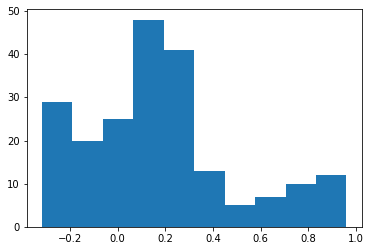

In [30]:
import plotly.graph_objects as go
X = env.DEALER_FIRST_CARD_SPACE
Y = env.PLAYER_SOCRE
Z = []
for dfc in X:
    for ps in Y:
        state = (dfc, ps)
        z = np.max([agent.Q[state, 0], agent.Q[state, 1]])
        Z.append(z)
        #print(z)
Z = np.array(Z)
plt.hist(Z)
Z = Z.reshape((Y.shape[0], X.shape[0]))
print(X.shape, Y.shape, Z.shape)

In [55]:
import plotly.figure_factory as FF
from scipy.spatial import Delaunay

u = np.linspace(0, 2*np.pi, 21)
v = np.linspace(0, 2*np.pi, 10)
u,v = np.meshgrid(u,v)
u = u.flatten()
v = v.flatten()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig = FF.create_trisurf(z=Z, x = X, y = Y, simplices=simplices)

scene = dict(
    xaxis = dict(nticks=10, range=[1,10], tick0 = 1),
    yaxis = dict(nticks=7, range=[1,21], ticks='outside', tick0 = 1),
    zaxis = dict(nticks=10, range=[np.min(Z) - 0.5, np.max(Z) + 0.5],),
    xaxis_title='Dealer',
    yaxis_title='Player',
    zaxis_title='Value',
)
fig.update_layout(scene = scene,
                  title = 'MonteCarlo Control',
                  autosize = True,
                  width=700, 
                  height=500,
                  margin = dict(l=65, r=50, b=65, t=90)
)
fig.show()

# Matplot

In [0]:
 X, Y, Z = [], [], []
for dealer in range(1, 11):
    for player in range(1, env.MAX_VALUE + 1):
        state = dealer, player
        X.append(dealer)
        Y.append(player)
        Z.append(max(agent.Q[state, 0], agent.Q[state, 1]))
from matplotlib import cm

([<matplotlib.axis.XTick at 0x7fa7ca07e2e8>,
 <a list of 10 Text major ticklabel objects>)

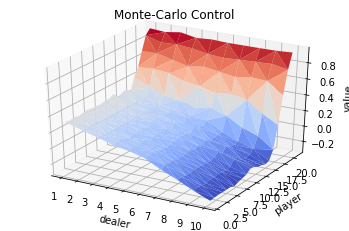

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm)

ax.set_xlabel('dealer')
ax.set_ylabel('player')
ax.set_zlabel('value')
plt.title('Monte-Carlo Control')
plt.xticks(np.arange(1, 11))